In [1]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt

In [2]:
with open("../../../data/train_test_split/test_folders.json", "r") as train_file:
    test_folders = json.load(train_file)

In [3]:
df = pd.read_csv('../../../data/base_models/gpt4/temperature5_eval.csv')
lisa_sheets = pd.read_csv('../../../data/lisa_sheets.csv')
df = pd.merge(df, lisa_sheets[['id', 'folder']], how='left', on='id')
df = df[df['folder'].isin(test_folders)]
df.head()

,id,mcq_json,rubric,question,option_a,option_b,option_c,option_d,correct_option,content_gpt,...,starts_with_negation,is_question,relevance,ambiguity,gpt_answer,disclosure,difficulty,avg_distractor_quality,min_distractor_quality,folder
31,OIC-328-06-B,{'question': 'Which type of orthosis is primar...,Management of costs,Which type of orthosis is primarily used to im...,Immobilisation Orthoses,Function Orthoses,Posture Orthoses,Cervical Orthoses,b,**Item_parent:** Non-drug therapies and medica...,...,False,True,0.704742,0.837635,b,False,2,3,1,IC-328
32,OIC-328-12-B,{'question': 'What is the main difference betw...,Definition,What is the main difference between thermal me...,"Thermal medicine uses seawater, while thalasso...",Thalassotherapy is systematically supervised b...,Thermal medicine involves the use of mineral w...,Thalassotherapy treatments are reimbursed by H...,c,**Item_parent:** Non-drug therapies and medica...,...,False,True,0.733706,0.888077,c,False,4,3,1,IC-328
33,OIC-328-05-A,{'question': 'What is the primary purpose of a...,Definition,What is the primary purpose of an orthosis in ...,To assist in surgical recovery,To enhance the mobility of healthy limbs,To stabilize or correct a deficient limb or spine,To replace missing limbs,c,**Item Parent:** Non-drug therapies and medica...,...,False,True,0.759086,0.751152,c,False,5,3,1,IC-328
34,OIC-328-08-A,{'question': 'What is the primary purpose of a...,Definition,What is the primary purpose of a limb prosthes...,To enhance aesthetic appearance,For functional purposes,To prevent further amputation,To increase muscle strength,b,**Item Parent:** Non-drug therapies and medica...,...,False,True,0.787791,0.660847,b,False,5,3,1,IC-328
35,OIC-328-02-A,{'question': 'What is the primary purpose of t...,Definition,What is the primary purpose of the EU regulati...,To regulate the prices of medical devices.,To standardize the marketing and commissioning...,To control the reimbursement of medical device...,To define medical devices as products of human...,b,**Item Parent:** Non-drug therapies and medica...,...,False,True,0.776859,0.752327,b,False,5,3,1,IC-328


In [4]:
len(df)

1524

In [5]:
df['correct_option'].unique()

array(['b', 'c', 'a', 'd', 'option_c', 'option_d', 'option_b'],
      dtype=object)

In [6]:
# normalize correct_option
df['correct_option'] = df['correct_option'].replace({'option_b': 'b', 'option_c': 'c', 'option_d': 'd', 'option_a': 'a'}) 

# Question mark

In [7]:
# We want to maximize 'True'
question_freqs = {
    'True': round(df['is_question'].sum()/ len(df) * 100, 2),
    'False': round((len(df) - df['is_question'].sum()) / len(df) * 100, 2)
}

question_freqs

{'True': np.float64(100.0), 'False': np.float64(0.0)}

# Negation

In [8]:
# We want to minimze 'True'
starts_with_negation_freqs = {
    'True': round(df['starts_with_negation'].sum() / len(df) * 100, 2),
    'False': round((len(df) - df['starts_with_negation'].sum()) / len(df) * 100, 2)
}

starts_with_negation_freqs

{'True': np.float64(0.0), 'False': np.float64(100.0)}

# Readability

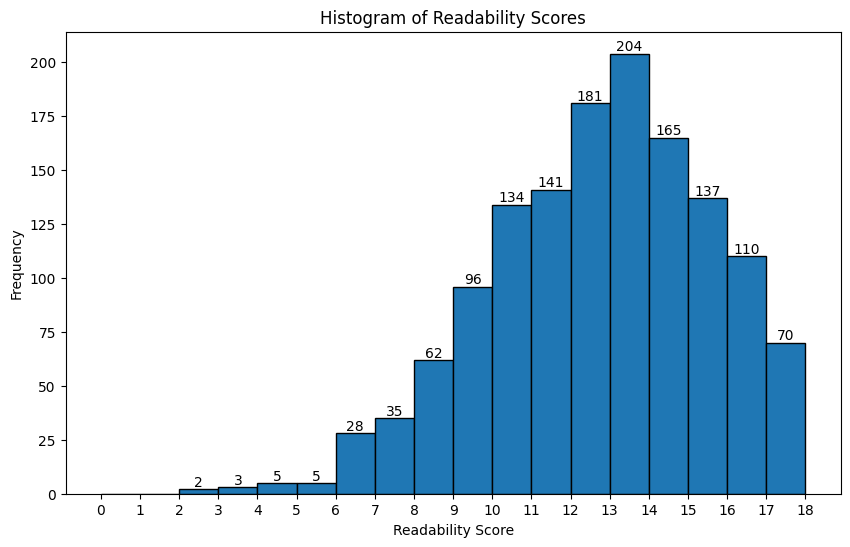

In [9]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['readability'], bins=range(0, 19, 1), edgecolor='black')

# Set x-axis ticks from 0 to 18
plt.xticks(range(0, 19))

# Add frequency labels on top of each bar where frequency > 0
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.show()

In [10]:
df['readability'].describe()

count    1524.000000
mean       13.442463
std         3.503400
min         2.342222
25%        11.130000
50%        13.372727
75%        15.640000
max        32.654286
Name: readability, dtype: float64

# Originality

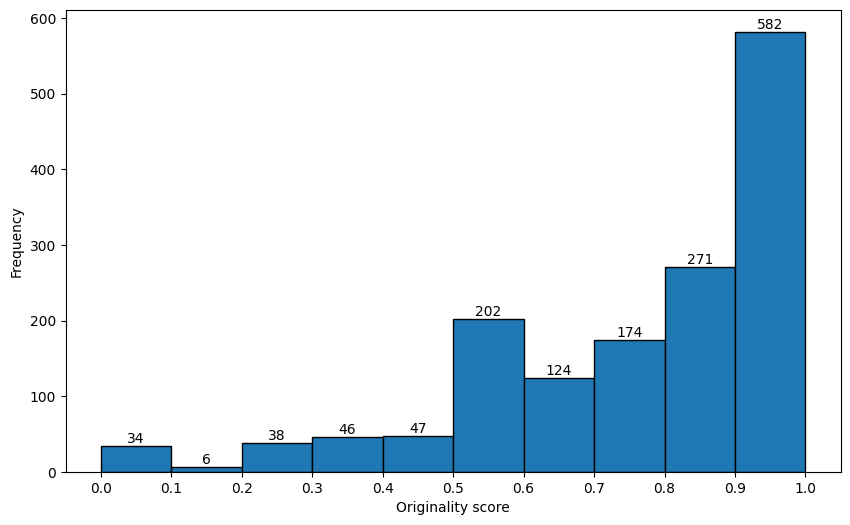

In [11]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['originality'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Originality score')
plt.ylabel('Frequency')
plt.show()

In [12]:
df['originality'].describe()

count    1524.000000
mean        0.768635
std         0.245764
min         0.000000
25%         0.625000
50%         0.800000
75%         1.000000
max         1.000000
Name: originality, dtype: float64

# Answer Length

In [13]:
option_cols = ['option_a', 'option_b', 'option_c', 'option_d']

# Create new columns with word counts for each option column
for col in option_cols:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))

In [14]:
def get_correct_option_rank(row):
    # Get the original word counts for each option
    counts = [
        row['option_a_word_count'],
        row['option_b_word_count'],
        row['option_c_word_count'],
        row['option_d_word_count']
    ]

    # Map correct_option letter to its index (0 for A, 1 for B, etc.)
    letter_to_index = {'A': 0, 'a':0, 'B': 1, 'b':1, 'C': 2, 'c':2, 'D': 3, 'd':3}
    correct_idx = letter_to_index[row['correct_option']]

    # Determine the word count of the correct option
    correct_count = counts[correct_idx]

    # Create an effective counts list:
    # For non-correct options, if their word count equals the correct option's word count,
    # treat them as if they had one extra word.
    effective_counts = []
    for i, count in enumerate(counts):
        if i != correct_idx and count == correct_count:
            effective_counts.append(count + 1)
        else:
            effective_counts.append(count)

    # Sort the option indices by descending effective count.
    ordering = sorted(range(4), key=lambda i: effective_counts[i], reverse=True)

    # Compute the rank as the 1-indexed position of the correct option in the ordering.
    rank = ordering.index(correct_idx) + 1
    return rank

In [15]:
def get_rank_distribution(df):
  rank_distribution = df['correct_option_rank'].value_counts().sort_index()
  rank_distribution = round(rank_distribution / len(df), 2) * 100

  plt.figure(figsize=(8, 6))
  plt.bar(rank_distribution.index, rank_distribution.values, color='skyblue', edgecolor='black')
  plt.xlabel('N (1 = Longest, 4 = Shortest)')
  plt.ylabel('Frequency, %')
  plt.title('How often the correct option is N`th longest')
  plt.xticks([1, 2, 3, 4])
  plt.show()

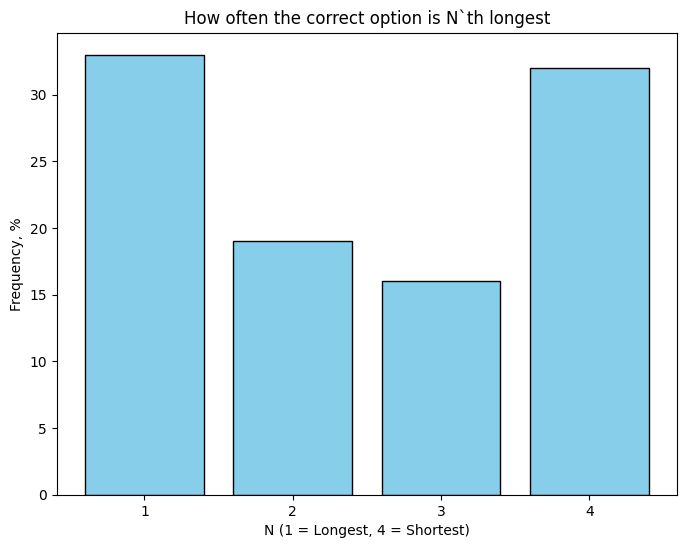

In [16]:
df['correct_option_rank'] = df.apply(get_correct_option_rank, axis=1)
get_rank_distribution(df)

# Disclosure

In [17]:
disclosure_freqs = {
    'True': round((df['disclosure'].sum() / len(df)) * 100, 2),
    'False': round((len(df) - df['disclosure'].sum()) / len(df) * 100, 2)
}

disclosure_freqs

{'True': np.float64(9.65), 'False': np.float64(90.35)}

# Relevance to the input material

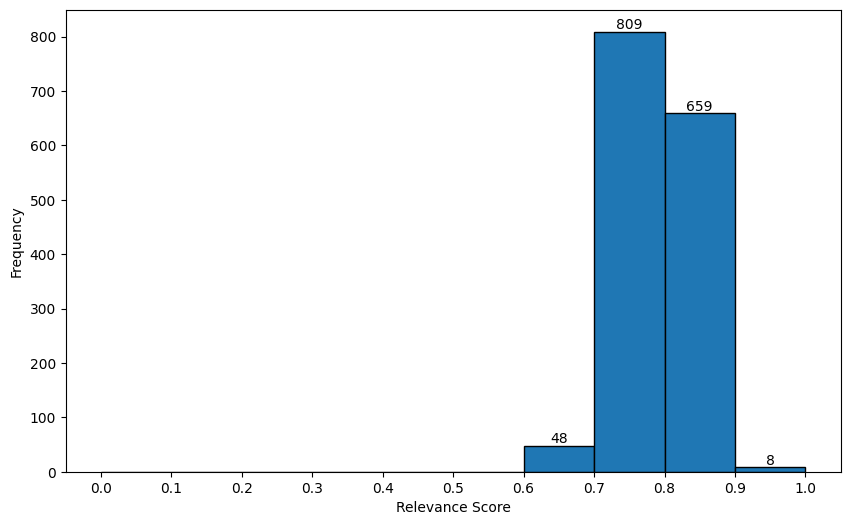

In [18]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['relevance'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

In [19]:
df['relevance'].describe()

count    1524.000000
mean        0.790329
std         0.046388
min         0.612431
25%         0.761819
50%         0.792100
75%         0.822701
max         0.935077
Name: relevance, dtype: float64

# Ambiguity (cosine similarity)

Text(0.5, 1.0, 'Distribution of Ambiguity')

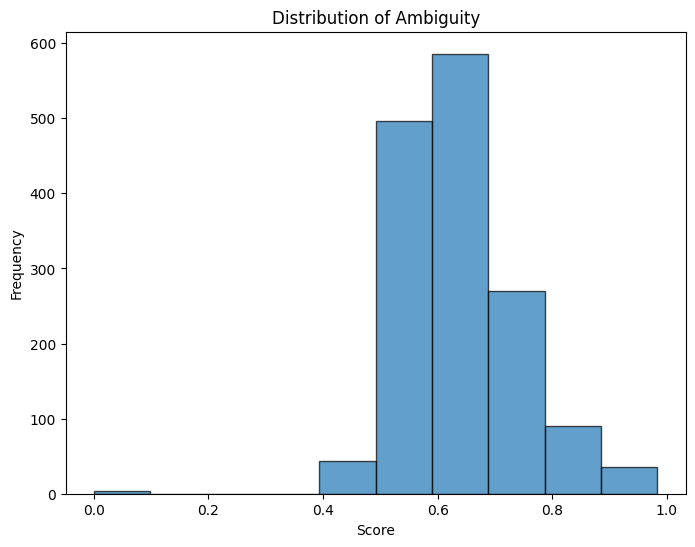

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(df['ambiguity'], bins=10, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Ambiguity")

In [21]:
df['ambiguity'].describe()

count    1524.000000
mean        0.635420
std         0.101763
min         0.000000
25%         0.564703
50%         0.622674
75%         0.690376
max         0.983639
Name: ambiguity, dtype: float64

# Difficulty (judge LLM)

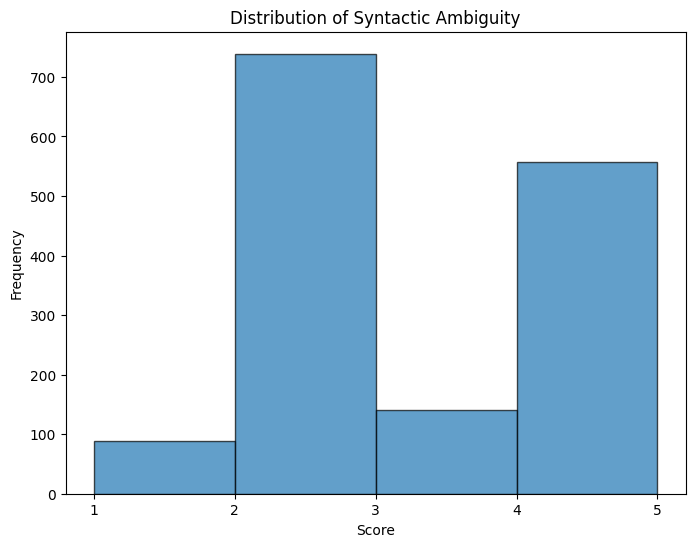

In [22]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['difficulty'], bins=np.arange(1, 6), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Syntactic Ambiguity")
plt.xticks(range(1, 6))

# Show the plot
plt.show()

In [23]:
df['difficulty'].describe()

count    1524.000000
mean        2.948163
std         1.276307
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: difficulty, dtype: float64

# Answerability
can judge model answer the generated question with context provided?

In [24]:
df['gpt_answer'].unique()

array(['b', 'c', 'a', 'd'], dtype=object)

In [25]:
df['correct_option'].unique()

array(['b', 'c', 'a', 'd'], dtype=object)

In [26]:
answerability_freqs = {
    'True': round((df['correct_option'] == df['gpt_answer']).sum() / len(df) * 100, 2), 
    'False': round((len(df) - (df['correct_option'] == df['gpt_answer']).sum()) / len(df) * 100, 2)
}

answerability_freqs

{'True': np.float64(99.61), 'False': np.float64(0.39)}

# Distractors Quality

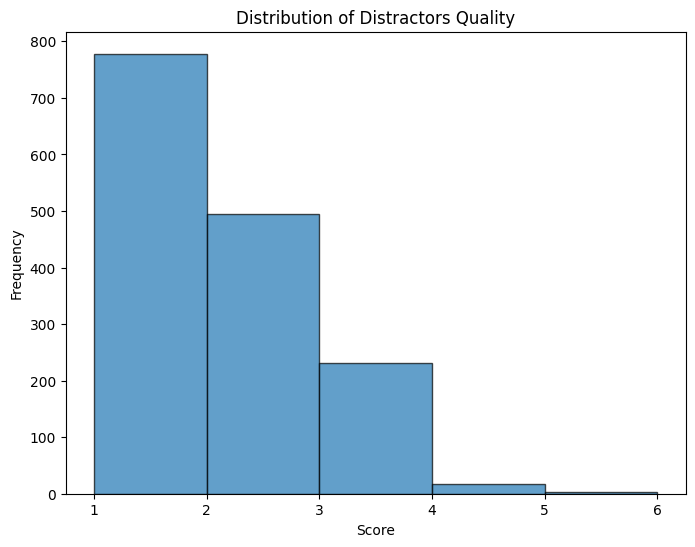

In [27]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['min_distractor_quality'], bins=np.arange(1, 7), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Distractors Quality")
plt.xticks(range(1, 7))

# Show the plot
plt.show()

In [28]:
df['min_distractor_quality'].describe()

count    1524.000000
mean        1.669948
std         0.785198
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: min_distractor_quality, dtype: float64

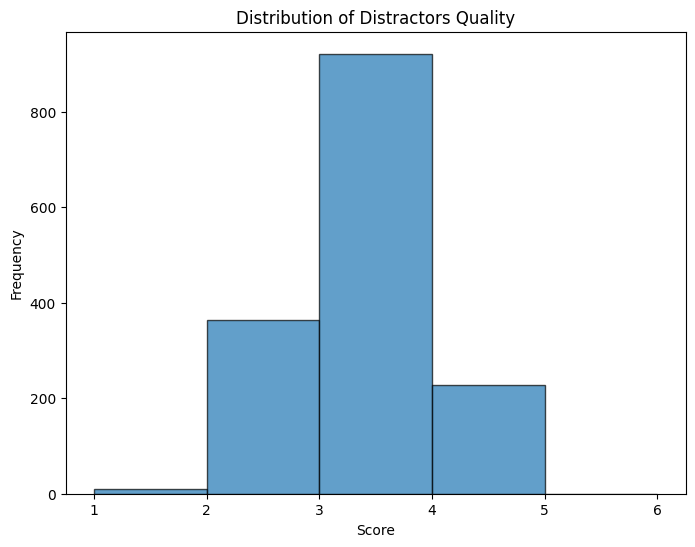

In [29]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['avg_distractor_quality'], bins=np.arange(1, 7), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Distractors Quality")
plt.xticks(range(1, 7))

# Show the plot
plt.show()

In [30]:
df['avg_distractor_quality'].describe()

count    1524.000000
mean        2.898294
std         0.634547
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: avg_distractor_quality, dtype: float64